# Find cropped area on dense grid

This notebook creates a grid at 0.01 degree resolution (roughly 1 km^2) and calculates the crop land percentage by counting the cropped pixels and dividing by the total number of pixels in each grid cell. A point is returned (the center of a 0.01 by 0.01 degree cell) with the corresponding crop area percentage for that cell. These points can then be used in the featurization process. This dataaset has 30 meter resolution.

In [1]:
import rasterio
from rasterio.plot import show
import rasterio.warp
import rasterio.mask
import shapely.geometry
from affine import Affine
import warnings
import time
import os

RASTERIO_BEST_PRACTICES = dict(  # See https://github.com/pangeo-data/cog-best-practices
    CURL_CA_BUNDLE="/etc/ssl/certs/ca-certificates.crt",
    GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
    AWS_NO_SIGN_REQUEST="YES",
    GDAL_MAX_RAW_BLOCK_CACHE_SIZE="200000000",
    GDAL_SWATH_SIZE="200000000",
    VSI_CURL_CACHE_SIZE="200000000",
)
os.environ.update(RASTERIO_BEST_PRACTICES)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import geopandas
from osgeo import gdal

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from pyhere import here

## Set parameters

In [2]:
cell_size = 0.129  # Roughly 1 km
geodetic_epsg = 'EPSG:4326'
country_code = 'ZMB' # 'TZA' # 'NGA'
# data_dir = "/capstone/cropmosaiks/data"  
data_dir = here("data")  

## Create a dense grid of points
This uses equal angle projection WGS 84 at 0.01 degree resolution (roughly 1 km^2) to create a grid of points which represent the center of each cell. The gris is specified around a given country and then cropped to the exact outline of the country.

In [3]:
points = pd.read_feather(here("data", 'land_cover', 'ZMB_cropland_percentage_4k-points_1.feather'))
points = points[["lon", "lat"]].to_numpy()
points.shape

(3772, 2)

In [25]:
# %%time
# ### get country shape
# country_file_name = f"{data_dir}/geo_boundaries/africa_adm0.geojson"
# africa = geopandas.read_file(country_file_name)
# country = africa[africa.adm0_a3 == country_code]
# #### This would be simpler, but throws an error down the line if used 
# # world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# # country = world.query(f'iso_a3 == "{country_code}"')
# ### Create grid of points
# xmin, ymin, xmax, ymax = country.total_bounds
# xs = list(np.arange(xmin, xmax + cell_size, cell_size))
# ys = list(np.arange(ymin, ymax + cell_size, cell_size))
# def make_cell(x, y, cell_size):
#     ring = [
#         (x, y),
#         (x + cell_size, y),
#         (x + cell_size, y + cell_size),
#         (x, y + cell_size)
#     ]
#     cell = shapely.geometry.Polygon(ring).centroid
#     return cell
# center_points = []
# for x in xs:
#     for y in ys:
#         cell = make_cell(x, y, cell_size)
#         center_points.append(cell)
# ### Put grid into a GeDataFrame for cropping to country shape
# gdf = geopandas.GeoDataFrame({'geometry': center_points}, crs = geodetic_epsg)
# gdf['lon'], gdf['lat'] = gdf.geometry.x, gdf.geometry.y
# ### Subset to country 
# ### The buffer ensures that no points are take at the border 
# ### which would lead to duplication with neighboring countries
# ### and finding cropland percentage outside of border
# gdf = gdf[gdf.within(country.unary_union.buffer(cell_size/2))]
# gdf = gdf[['lon', 'lat', 'geometry']].reset_index(drop = True)
# points = gdf[["lon", "lat"]].to_numpy()
# gdf.shape

CPU times: user 1.54 s, sys: 0 ns, total: 1.54 s
Wall time: 1.53 s


(3968, 2)

## Clip the cropland raster to a country

In [8]:
### https://glad.umd.edu/dataset/croplands
### full file name
# full_raster = f"{data_dir}/land_cover/Global_cropland_NW_2019.tif"
# full_raster = f"{data_dir}/land_cover/Global_cropland_SW_2019.tif"
# full_raster = f"{data_dir}/land_cover/Global_cropland_NE_2019.tif"
full_raster = f"{data_dir}/land_cover/Global_cropland_SE_2019.tif"
### file name of cropped raster
croped_raster = f"{data_dir}/land_cover/{country_code}_cropland_2019.tif"

In [5]:
### This takes a long time, only do once
# gdal.Warp(
#     destNameOrDestDS = croped_raster, 
#     srcDSOrSrcDSTab  = full_raster,  
#     outputBounds     = country.total_bounds,
#     cropToCutline    = True,
#     copyMetadata     = True,
#     creationOptions = ['COMPRESS=LZW']
# )

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f625e166fc0> >

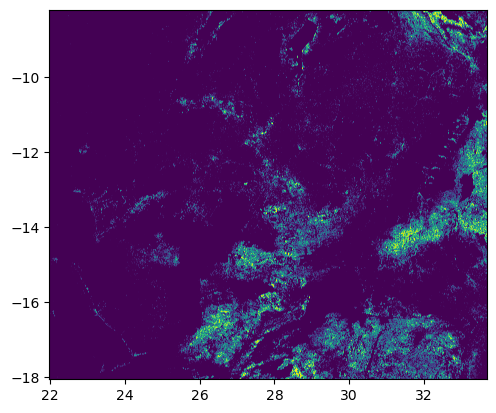

<AxesSubplot:>

In [9]:
### Optionally show the raster
f = rasterio.open(croped_raster)
show(f)

## Create CustomDataset

In [10]:
class CustomDataset(Dataset):
    def __init__(self, points, buffer=cell_size/2):
        self.points = points
        self.buffer = buffer

    def __len__(self):
        return self.points.shape[0]

    def __getitem__(self, idx):

        lon, lat = self.points[idx]
        
        point_geom = shapely.geometry.mapping(shapely.geometry.Point(lon, lat))

        with rasterio.Env():
            with rasterio.open(croped_raster, "r") as f:
                point_shape = shapely.geometry.shape(point_geom)
                mask_shape = point_shape.buffer(self.buffer).envelope
                mask_geom = shapely.geometry.mapping(mask_shape)
                try:
                    out_image, out_transform = rasterio.mask.mask(
                        f, [mask_geom], crop=True
                    )
                except ValueError as e:
                    if "Input shapes do not overlap raster." in str(e):
                        return None

        out_image = out_image.squeeze()
        out_image = torch.from_numpy(out_image).float()
        return out_image

## Load our Dataset
Feed in our dense grid of points into the CustomDataset to get our dataset.

In [11]:
dataset = CustomDataset(points)

## View example

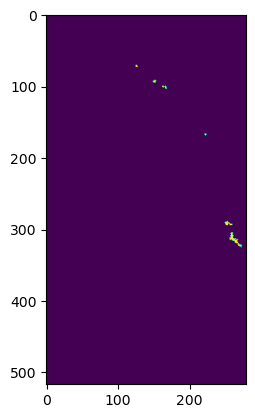

In [12]:
img = dataset[0]
plt.figure()
plt.imshow(img)
plt.show()
plt.close()

Note the 30 meter resolution of the plot means 41 pixels is 1,230 meters. 

In [13]:
img.shape

torch.Size([517, 279])

Here we see how the cropland perccentage is being caluculated. 

In [14]:
((img == 1).sum() / img.numel()).item()

0.0012062976602464914

## Initialize DataLoader 

In [15]:
dataloader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=False,
    num_workers=os.cpu_count(),
    collate_fn=lambda x: x,
    pin_memory=False,
)

## Find cropland percentage for all points in dense grid
This is done with parallel proccessing through our PyTorch dataloader.

In [16]:
%%time
x_all = np.zeros((points.shape[0], 1), dtype=float)
tic = time.time()
i = 0
for images in dataloader:
    for image in images:
        if i % 25000 == 0:
            print(
                f"{i}/{points.shape[0]} -- {i / points.shape[0] * 100:0.2f}%"
                + f" -- {time.time()-tic:0.2f} seconds"
            )
            tic = time.time()
        crops = (image == 1).sum() / image.numel()
        x_all[i] = crops.item()

        i += 1

0/3772 -- 0.00% -- 3.50 seconds
CPU times: user 3min 57s, sys: 13 s, total: 4min 10s
Wall time: 12.1 s


## Put results into a pandas.DataFrame

In [17]:
crops = pd.DataFrame({'crop_perc': x_all.squeeze()})
crops[["lon", "lat"]] = points.tolist()

Plot the results

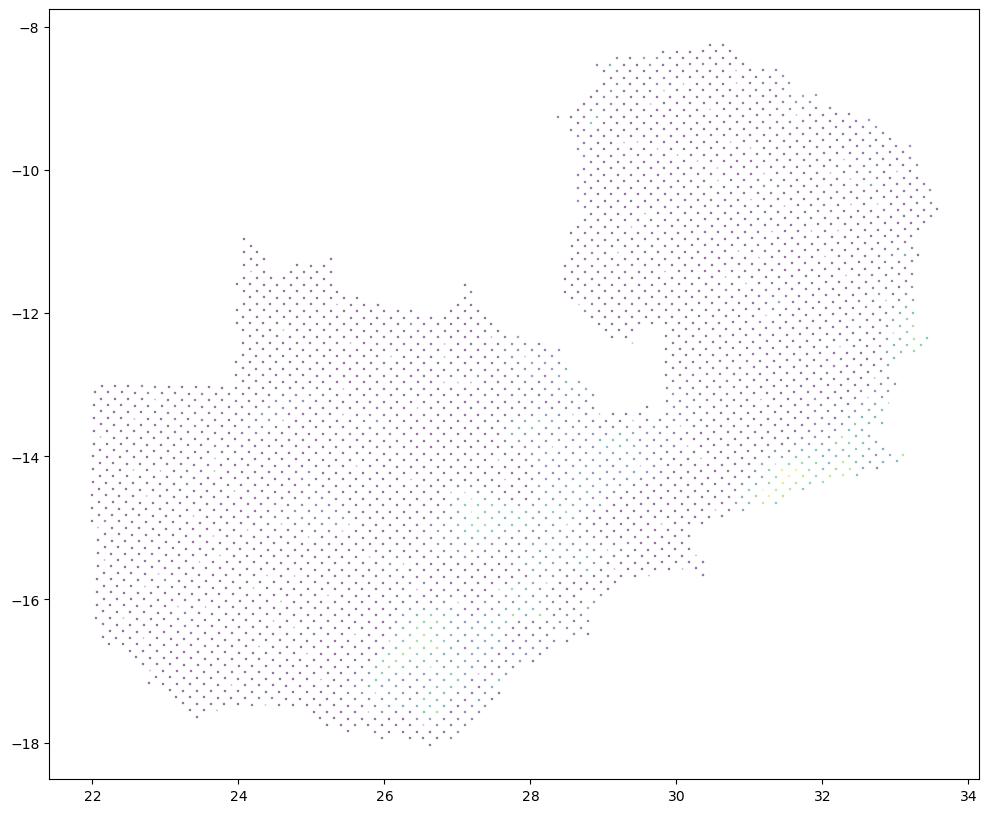

In [18]:
plt.figure(figsize = (12,10))
plt.scatter(
    crops.lon, 
    crops.lat, 
    c=crops.crop_perc, 
    s=.5,
    alpha =.5,
    marker = ','
)

Save the dense grid of points with cropland percentage as a feater file. 

In [21]:
### Save the dense grid file for crop_weights to a feather file
file_name = f'{country_code}_cropland_percentage_{len(points)/1000:0.0f}k-points.feather'
print("Saving file as:", file_name)
crops.to_feather(here('data', 'land_cover', file_name))
print("Save finished!")

Saving file as: ZMB_cropland_percentage_4k-points.feather
Save finished!


## Sample cropland

In [17]:
file_name_country_shp = f'{data_dir}/boundaries/gadm36_{country_code}_2.shp'

<AxesSubplot:>

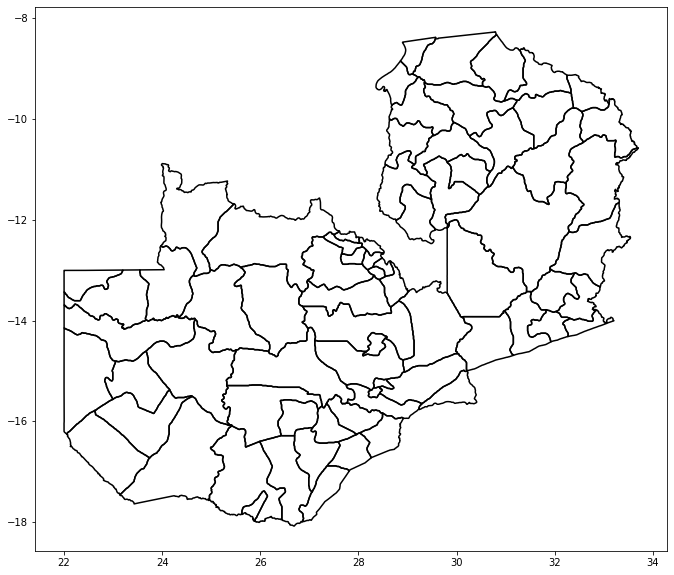

In [18]:
country_shp = geopandas.read_file(file_name_country_shp)
country_shp = country_shp.rename(columns = {'NAME_2': 'district'})[['district', 'geometry']]
country_shp.district = country_shp.district.replace("MPongwe", 'Mpongwe', regex=True)
country_shp.boundary.plot(figsize = (12,10), edgecolor = "black")

In [19]:
crop_full = pd.read_feather(file_name)

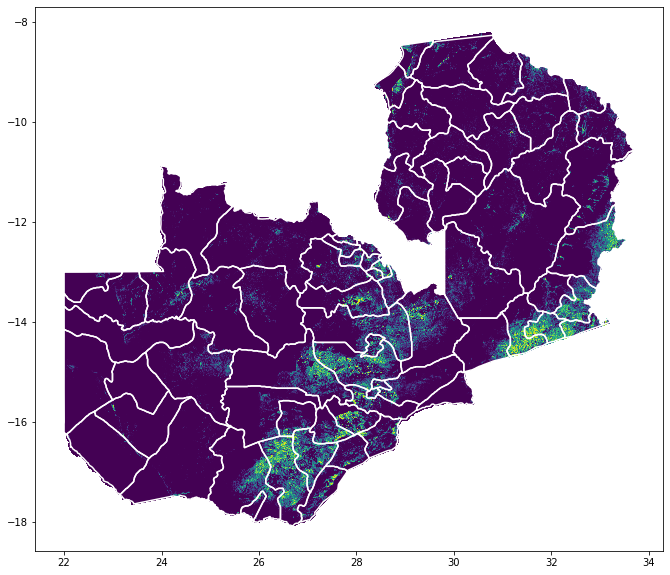

In [20]:
fig, ax = plt.subplots(figsize=(12, 10))
country_shp.boundary.plot(ax = ax, edgecolor = "white")
plt.scatter(crop_full.lon, crop_full.lat,  c=crop_full.crop_perc, s=.3, marker = ',')

In [21]:
crop_land = crop_full[crop_full.crop_perc > 0].reset_index(drop = True)

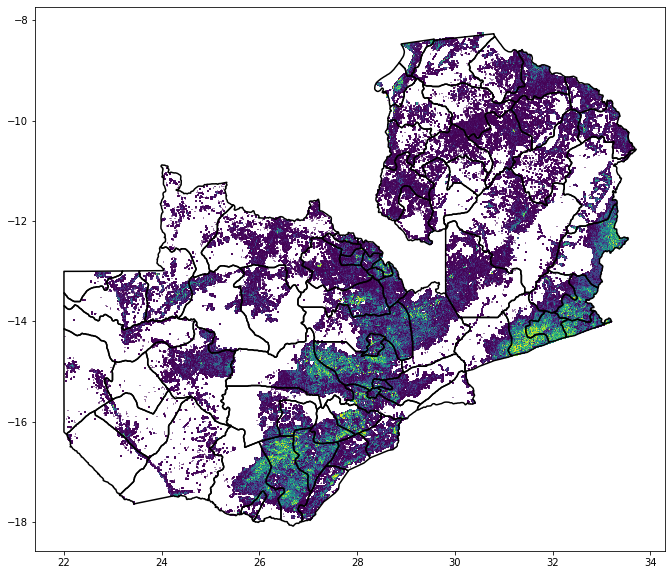

In [22]:
fig, ax = plt.subplots(figsize=(12, 10))
country_shp.boundary.plot(ax = ax, edgecolor = "black")
plt.scatter(crop_land.lon, crop_land.lat,  c=crop_land.crop_perc, s=.3, marker = ',')

In [23]:
crop_land = (
    geopandas
    .GeoDataFrame(
        crop_land, 
        geometry = geopandas.points_from_xy(x = crop_land.lon, y = crop_land.lat), 
        crs='EPSG:4326')
    .sjoin(country_shp, how = 'left', predicate = 'within')
    .drop('index_right', axis = 1)
    .dropna(subset = ['district'])
)

In [24]:
percentage = 0.10
crop_land_top_10_per_dist = (
    crop_land
    .groupby(['district'], as_index = False)
    .apply(lambda x: x.nlargest(int(x.count().max()*percentage),['crop_perc']))
    .reset_index(drop=True)
    .drop(['geometry', 'district'], axis = 1)
)
crop_land_top_10_per_dist = pd.DataFrame(crop_land_top_10_per_dist)

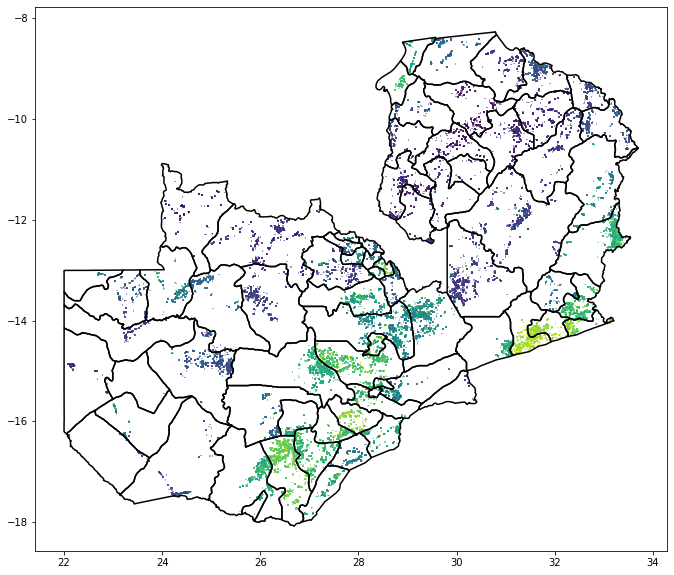

In [25]:
fig, ax = plt.subplots(figsize=(12, 10))
country_shp.boundary.plot(ax = ax, edgecolor = "black")
ax.scatter(x = crop_land_top_10_per_dist.lon, 
            y = crop_land_top_10_per_dist.lat, 
            c = crop_land_top_10_per_dist.crop_perc, 
            s = .3, marker = ',')

In [26]:
pts = len(crop_land_top_10_per_dist)/1000
file_name = f'{data_dir}/land_cover/{country_code}_cropland_percentage_{pts:0.0f}k-points.feather'
print("Saving file as:", file_name)
crop_land_top_10_per_dist.to_feather(file_name)
print("Save finished!")

Saving file as: /capstone/cropmosaiks/data/weights/ZMB_crop_weights_20k-points.feather
Save finished!
